<a href="https://colab.research.google.com/github/Zarathustra616/CV-and-ML/blob/main/VGG_Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ищем видяху Tesla P100-PCIE-16GB
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Model: 		 Tesla K80
IRQ:   		 35
GPU UUID: 	 GPU-2c18f26e-7f42-f3fe-7ff1-414b6dc6b524
Video BIOS: 	 80.21.25.00.01
Bus Type: 	 PCI
DMA Size: 	 40 bits
DMA Mask: 	 0xffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
Blacklisted:	 No


In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-v9t2s9t7
All libraries are successfully installed!


In [3]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-2xe41qgh
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-2xe41qgh
     |████████████████████████████████| 60.3 MB 36 kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29576 sha256=d8e4c2f2094f7a26652155a1618e996198a61ef1cba0a85575e1328a6f3e29cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-58htp7d_/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/'My Drive'/colab/with_mask.zip -d /content/
!unzip /content/gdrive/'My Drive'/colab/without_mask.zip -d /content/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/without_mask/5782  
  inflating: /content/without_mask/5783  
  inflating: /content/without_mask/5784  
  inflating: /content/without_mask/5785  
  inflating: /content/without_mask/5786  
  inflating: /content/without_mask/5787  
  inflating: /content/without_mask/5788  
  inflating: /content/without_mask/5789  
  inflating: /content/without_mask/579  
  inflating: /content/without_mask/5790  
  inflating: /content/without_mask/5791  
  inflating: /content/without_mask/5792  
  inflating: /content/without_mask/5793  
  inflating: /content/without_mask/5794  
  inflating: /content/without_mask/5795  
  inflating: /content/without_mask/5796  
  inflating: /content/without_mask/5797  
  inflating: /content/without_mask/5798  
  inflating: /content/without_mask/5799  
  inflating: /content/without_mask/58  
  inflating: /content/without_mask/58.jpg  
  inflating: /content/without_mask/580  
  inflatin

In [6]:
import io
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from typing import Optional, Tuple, List, Union

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from ImageDataAugmentor.image_data_augmentor import *
from albumentations import Compose, HorizontalFlip, Rotate

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG19, VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
def preprocessing_img(label: Optional[str], data: List[Image.Image], labels: List[str], path_imgs: Optional[str], size: Tuple[int, int]) -> None:
  """Подготавливает изображения для нейронной сети """  
  #Получает список всех изображений
  path_dir = os.listdir(path_imgs)
  #imagePath: Проходит по всем изображениям
  for imagePath in path_dir:
    # Загружает изображение из заданной папки
    image = load_img(path_imgs+imagePath, target_size=size)
    # Преобразует в массив numpy
    image = img_to_array(image)
    # Преобразует для подачи в нейронку VGG16  
    image = preprocess_input(image)
    #Заполняет list массивами
    data.append(image)
    labels.append(label)
  print('---Ready---> ' + label)

In [9]:
def augmentation_imgs(p: Optional[int]=0.5):
  """Создание дополнительных изображений""" 
  return Compose([
        HorizontalFlip(),                           # HorizontalFlip: повернутых горизонтально
        Rotate(limit=(-15, 15),border_mode=0),      # Rotate: вращение на 15 градусов
  ], p=p)                                           # р: вероятность изменения изрображения

In [10]:
path = dict(mask='/content/with_mask/',
            no_mask='/content/without_mask/',
            image='/content/j2ApoXbK30c.jpg',
            deploy='/content/gdrive/My Drive/colab/face_detector/deploy.prototxt',
            res_10='/content/gdrive/My Drive/colab/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

In [11]:
data = []
labels = []
preprocessing_img('with_mask', data, labels, path['mask'], (224, 224))
preprocessing_img('without_mask', data, labels, path['no_mask'], (224, 224))

---Ready---> with_mask
---Ready---> without_mask


In [12]:
# Создает Тензор 
# >>> data.shape
# >>> (5000, 224, 224, 3) Попробовать больше 5к
data = np.array(data[:5000], dtype="float32")
labels = np.array(labels[:5000])

# Преобразует название в классы 0 и 1
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [13]:
#Разбиваем на тренировку и проверку в пропорции 0.8 и 0.2
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
#Освобождаем память для найшей сессии
data = []

In [14]:
# Генератор дополнительных данных
aug = ImageDataAugmentor(augment=augmentation_imgs())
# Просмотр дополнительных данных
aug_show = aug.flow(X_train, y_train, batch_size=32)
# aug_show.show_batch()

VGG16

In [16]:

def VGG_16(weights_path=None):
    """VGG16 на tensorflow"""
    model = Sequential()
    model.add(ZeroPadding2D((1, 1),input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(GlobalMaxPooling2D())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    #Если есть готовые веса, то можно загрузить их
    if weights_path:
        model.load_weights(weights_path)

    return model
  

In [18]:
# Загрузка модели
model = VGG_16()
model.compile(loss='binary_crossentropy', optimizer=SGD(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [19]:
callbaks_list_vgg16 = [
    ModelCheckpoint(            #Сохраняет лучшую модель
        'VGG_16.h5', 
        monitor='val_accuracy', 
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(           # Ускоряеет обучение
        monitor='val_accuracy', 
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001
    ) 
]

In [20]:
# Обучаем VGG16
history_vgg16 = model.fit(aug.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    verbose=1,
                    callbacks=callbaks_list_vgg16,
                    validation_data=(X_test, y_test), 
                    steps_per_epoch=X_train.shape[0] // 32,
                    validation_steps=len(X_test) // 32)

Epoch 1/100
125/125 [==============================] - 174s 1s/step - loss: 0.6893 - accuracy: 0.5780 - val_loss: 0.6857 - val_accuracy: 0.5790

Epoch 00001: val_accuracy improved from -inf to 0.57900, saving model to VGG_16.h5
Epoch 2/100
125/125 [==============================] - 114s 916ms/step - loss: 0.6844 - accuracy: 0.5785 - val_loss: 0.6821 - val_accuracy: 0.5790

Epoch 00002: val_accuracy did not improve from 0.57900
Epoch 3/100
125/125 [==============================] - 114s 916ms/step - loss: 0.6825 - accuracy: 0.5785 - val_loss: 0.6800 - val_accuracy: 0.5790

Epoch 00003: val_accuracy did not improve from 0.57900
Epoch 4/100
125/125 [==============================] - 115s 916ms/step - loss: 0.6798 - accuracy: 0.5785 - val_loss: 0.6778 - val_accuracy: 0.5790

Epoch 00004: val_accuracy did not improve from 0.57900

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/100
125/125 [==============================] - 115s 916ms/step - loss: 0.67

KeyboardInterrupt: ignored

In [21]:
plt.figure(figsize=(10,10))
plt.plot(history_vgg16.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_vgg16.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.plot(history_vgg16.history['loss'], label='Loss верных ответов на обучающем наборе')  
plt.plot(history_vgg16.history['val_loss'], label='Loss верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.savefig("Plot")
plt.show()

NameError: ignored

<Figure size 720x720 with 0 Axes>

VGG19


In [26]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
vgg19 = VGG19(weights="imagenet", input_tensor=Input(shape=(224, 224, 3)),  include_top=False)
vgg19.summary()
print(vgg19.output)
head_vgg19 = vgg19.output
head_vgg19 = GlobalMaxPooling2D()(head_vgg19)
head_vgg19 = Dense(64, activation="relu")(head_vgg19)
head_vgg19 = Dropout(0.5)(head_vgg19)
head_vgg19 = Dense(64, activation="relu")(head_vgg19)
head_vgg19 = Dropout(0.5)(head_vgg19)
head_vgg19 = Dense(2, activation="softmax")(head_vgg19)

model_vgg19 = Model(inputs=vgg19.input, outputs=head_vgg19)
for layer in vgg19.layers:
	layer.trainable = False


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model_vgg19.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H_vgg19 = model_vgg19.fit(aug.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    verbose=1,
                    callbacks=callbaks_list,
                    validation_data=(X_test, y_test), 
                    steps_per_epoch=X_train.shape[0] // 32,
                    validation_steps=len(X_test) // 32)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


125/125 [==============================] - 70s 475ms/step - loss: 0.8255 - accuracy: 0.5575 - val_loss: 0.5785 - val_accuracy: 0.6920

Epoch 00001: accuracy improved from -inf to 0.55750, saving model to VGG19.h5
Epoch 2/100
125/125 [==============================] - 45s 364ms/step - loss: 0.6089 - accuracy: 0.6727 - val_loss: 0.4716 - val_accuracy: 0.8710

Epoch 00002: accuracy improved from 0.55750 to 0.67275, saving model to VGG19.h5
Epoch 3/100
125/125 [==============================] - 45s 364ms/step - loss: 0.5178 - accuracy: 0.7602 - val_loss: 0.3723 - val_accuracy: 0.9100

Epoch 00003: accuracy improved from 0.67275 to 0.76025, saving model to VGG19.h5
Epoch 4/100
125/125 [==============================] - 45s 364ms/step - loss: 0.4291 - accuracy: 0.8322 - val_loss: 0.2829 - val_accuracy: 0.9360

Epoch 00004: accuracy improved from 0.76025 to 0.83225, saving model to VGG19.h5
Epoch 5/100
125/125 [==============================] - 45s 364ms/step - loss: 0.3565 - accuracy: 0.8735

In [25]:
callbaks_list = [
    ModelCheckpoint(            #Сохраняет лучшую модель
        'VGG19.h5', 
        monitor='accuracy', 
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(           # Ускоряеет обучение
        monitor='accuracy', 
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001
    ) 
]

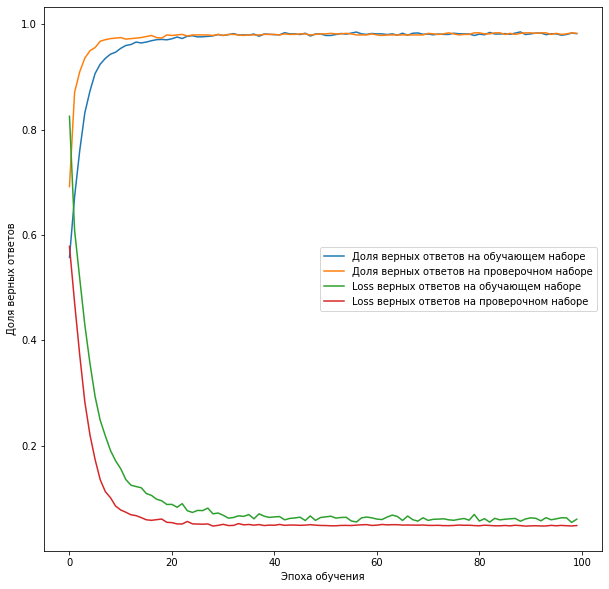

In [27]:
plt.figure(figsize=(10,10))
plt.plot(H_vgg19.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(H_vgg19.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.plot(H_vgg19.history['loss'], label='Loss верных ответов на обучающем наборе')  
plt.plot(H_vgg19.history['val_loss'], label='Loss верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.savefig("Plot")
plt.show()

mobilnet2

In [29]:

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model1 = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
baseModel.summary()
# train the head of the network
print("[INFO] training head...")
H = model1.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS,
  callbacks=callbaks_list)

9420800/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
125/125 [==============================] - 61s 122ms/step - loss: 0.3111 - accuracy: 0.8870 - val_loss: 0.0892 - val_accuracy: 0.9890

Epoch 00001: accuracy improved from -inf to 0.88700, saving model to mobilenet.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
125/125 [==============================] - 13s 106ms/step - loss: 0.0908 - accuracy: 0.9795 - val_loss: 0.0488 - val_accuracy: 0.9910

Epoch 00002: accuracy improved from 0.88700 to 0.97950, saving model to mobilenet.h5
Epoch 3/20
125/125 [==============================] - 13s 106ms/step - loss: 0.0602 - accuracy: 0.9883 - val_loss: 0.0402 - val_accuracy: 0.9910

Epoch 00003: accuracy improved from 0.97950 to 0.98825, saving model to mobilenet.h5
Epoch 4/20
125/125 [==============================] - 13s 106ms/step - loss: 0.0495 - accuracy: 0.9875 - val_loss: 0.0355 - val_accuracy: 0.9910

Epoch 00004: accuracy did not improve from 0.98825
Epoch 5/20
125/125 [==============================] - 13s 105ms/step - loss: 0.0416 - accuracy: 0.9905 - val_loss: 0.0355 - val_accuracy: 0.9900

Epoch 00005: accuracy improved from 0.98825 to 0.99050, saving model to mobilenet.h5
Epoch 6/20
125/125 [==============================] - 13s 105ms/step - loss: 0.0335 - accuracy: 0.9920 - val_l

In [30]:
callbaks_list = [
    ModelCheckpoint(            #Сохраняет лучшую модель
        'mobilenet.h5', 
        monitor='accuracy', 
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(           # Ускоряеет обучение
        monitor='accuracy', 
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001
    ) 
]

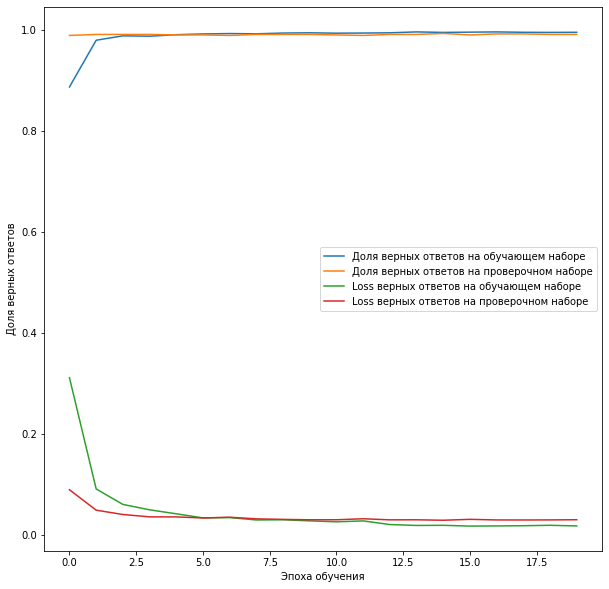

In [31]:
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(H.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.plot(H.history['loss'], label='Loss верных ответов на обучающем наборе')  
plt.plot(H.history['val_loss'], label='Loss верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.savefig("Plot")
plt.show()  